In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

# Closed Loop implemented as Neural ODE

## Past models of myosin dynamics

Increasing sparsity:

    D_t m_ij  = 1.431 m_ij Tr(E_passive)
    D_t m_ij = 0.305 * Tr(m) * m_ij - 0.160 * {m, E}
    D_t m_ij  = 0.007 Static_DV Tr(m_ij) + 1.368 m_ij Tr(E_passive) + 0.188 m_ij Tr(m_ij)
    D_t m_ij  = 0.024 Static_DV Tr(m_ij) + -0.023 m_ij + 1.335 m_ij Tr(E_passive) + 0.152 m_ij Tr(m_ij)
    D_t m_ij  = 0.095 Static_DV Tr(m_ij) + -0.001 m_ij + 1.402 m_ij Tr(E_passive) + 0.220 m_ij Tr(m_ij) + 0.008 {m_ij, E_passive} + -0.054 {m_ij, Static_DV}
    D_t m_ij  = -0.001 E_passive + 0.034 E_passive Tr(m_ij) + 0.122 Static_DV Tr(m_ij) + 0.030 m_ij + 1.357 m_ij Tr(E_passive) + -0.075 m_ij Tr(m_ij) + 0.332 m_ij m_ij + -0.021 {m_ij, E_passive} + -0.083 {m_ij, Static_DV}

Without a dorsal source:

    D_t m_ij  = -0.010 m_ij + 1.351 m_ij Tr(E_passive) + 0.012 Static_DV Tr(m_ij) + 0.221 m_ij Tr(m_ij)

With a dorsal source:

    D_t m_ij  = -0.016 m_ij + 1.319 m_ij Tr(E_passive) + 0.022 Static_DV Tr(m_ij) + 0.129 m_ij Tr(m_ij) + 0.026 Dorsal_Source m_ij + -0.290 Dorsal_Source m_ij Tr(E_passive) + -0.003 Dorsal_Source Static_DV + 0.007 Dorsal_Source m_ij Tr(m_ij)        

Closed loop PINN version 03232023:

    D_t m = -(0.514 - 0.549 s) m + (1.34 - 1 s){m, E_p} + (1.74 - 1.77 s) Tr(m) Gamma^{DV} + (1.66 - 1.68 s) Tr(m) m

Closed loop PINN version 03282023:

    D_t m = -(0.644 - 1.09 s) m + (1.02 - 1.2 s){m, E_p} + (0.891 - 1.47 s) Tr(m) Gamma^{DV} + (0.866 - 1.43 s) Tr(m) m

With ensemble-averaged cadherin:

    D_t m_ij  = 0.051 Static_DV Tr(m_ij) + -0.037 c Static_DV Tr(m_ij) + 0.077 c m_ij + -0.216 c m_ij Tr(E_full) + 1.003 c m_ij Tr(E_passive) + -0.528 c m_ij Tr(m_ij) + -0.085 m_ij + 1.465 m_ij Tr(E_full) + -1.814 m_ij Tr(E_passive) + 0.717 m_ij Tr(m_ij)

    D_t m_ij  = 0.047 Static_DV Tr(m_ij) + -0.034 c Static_DV Tr(m_ij) + 0.061 c m_ij + 0.310 c m_ij Tr(E_full) + -0.393 c m_ij Tr(m_ij) + -0.066 m_ij + 0.489 m_ij Tr(E_full) + 0.564 m_ij Tr(m_ij)

## Fly closed loop

Initializing
Using torchdiffeq solver


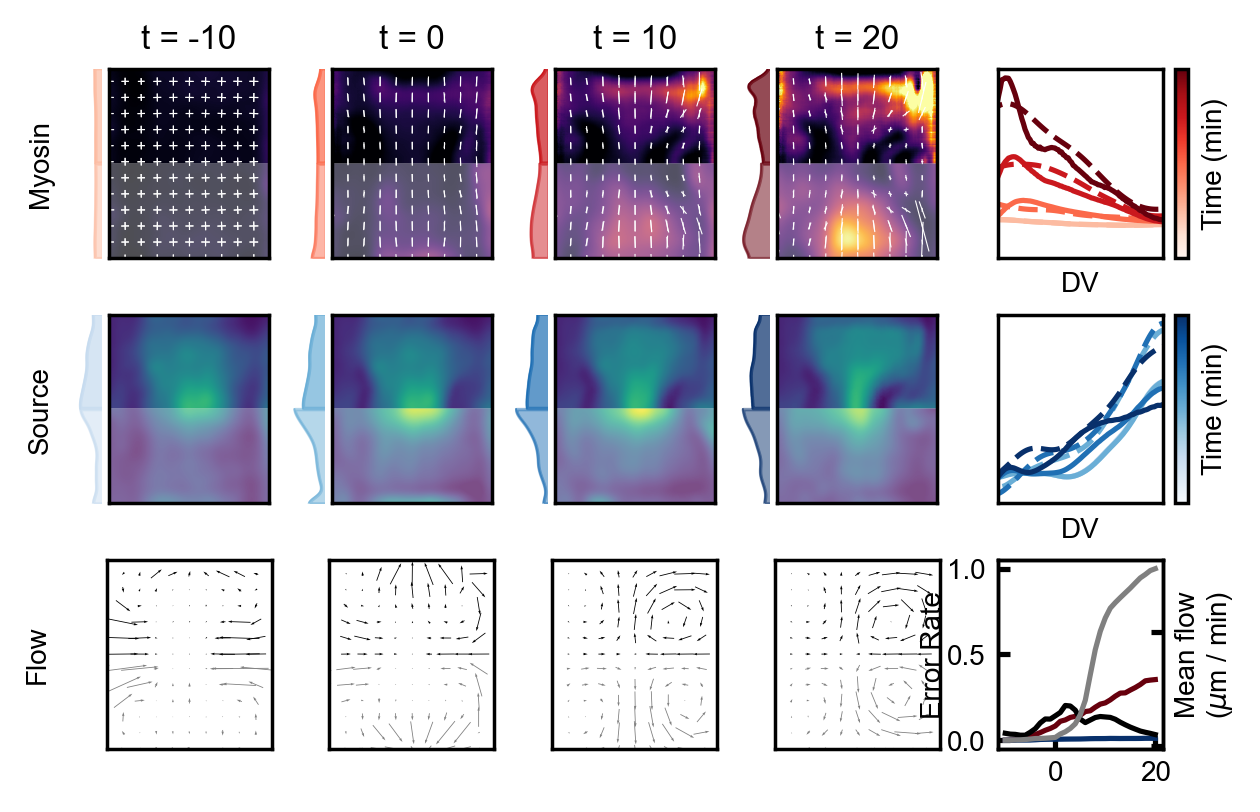

In [17]:
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from vae_models.convnext_models import *

info = torch.load('../tb_logs/MaskedVAE_Evolver_sqh_beta=0_split=embryo')
vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vae = vae.double().to(device).eval();
v_model = lambda t, y: VAE.forward(vae, y.reshape([-1, *y.shape[-3:]])[:, :4])[0]

model = ClosedFlyLoop(v_model, 
                      v_thresh=0.,
                      sigma=7)

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model.fit(y0[None])

#Send to device
model.to(device)
y0 = y0.to(device)
t = torch.DoubleTensor(t0).to(device)

m, s, v = model.integrate(y0, t)

#sqh_vel_plot(m, v, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m, m0),
                ('Source', s, s0),
                ('Flow', v, v0),
                dt=10)

Initializing
Using scipy solve_ivp


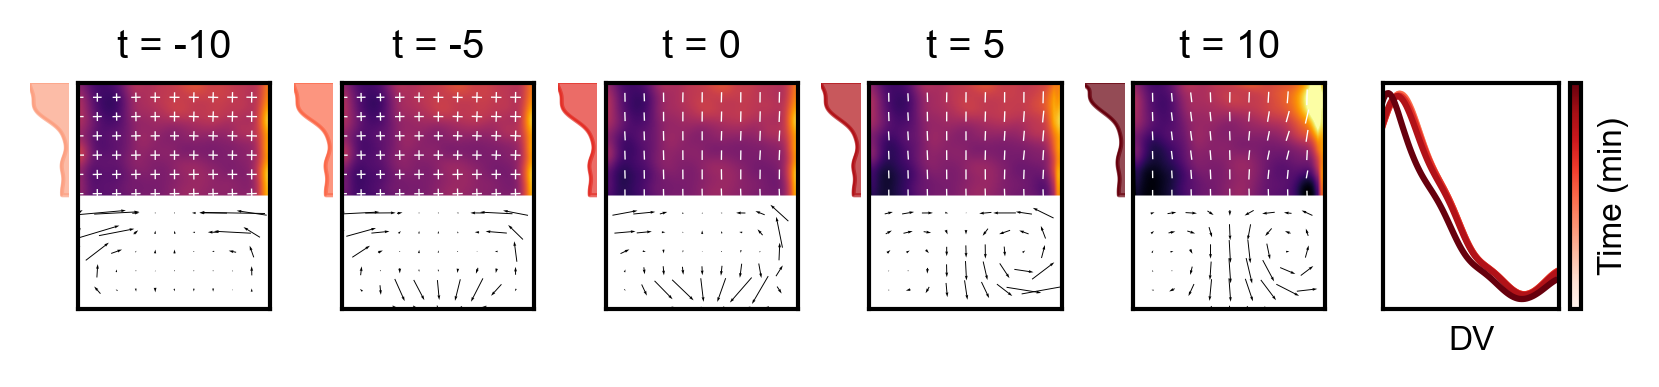

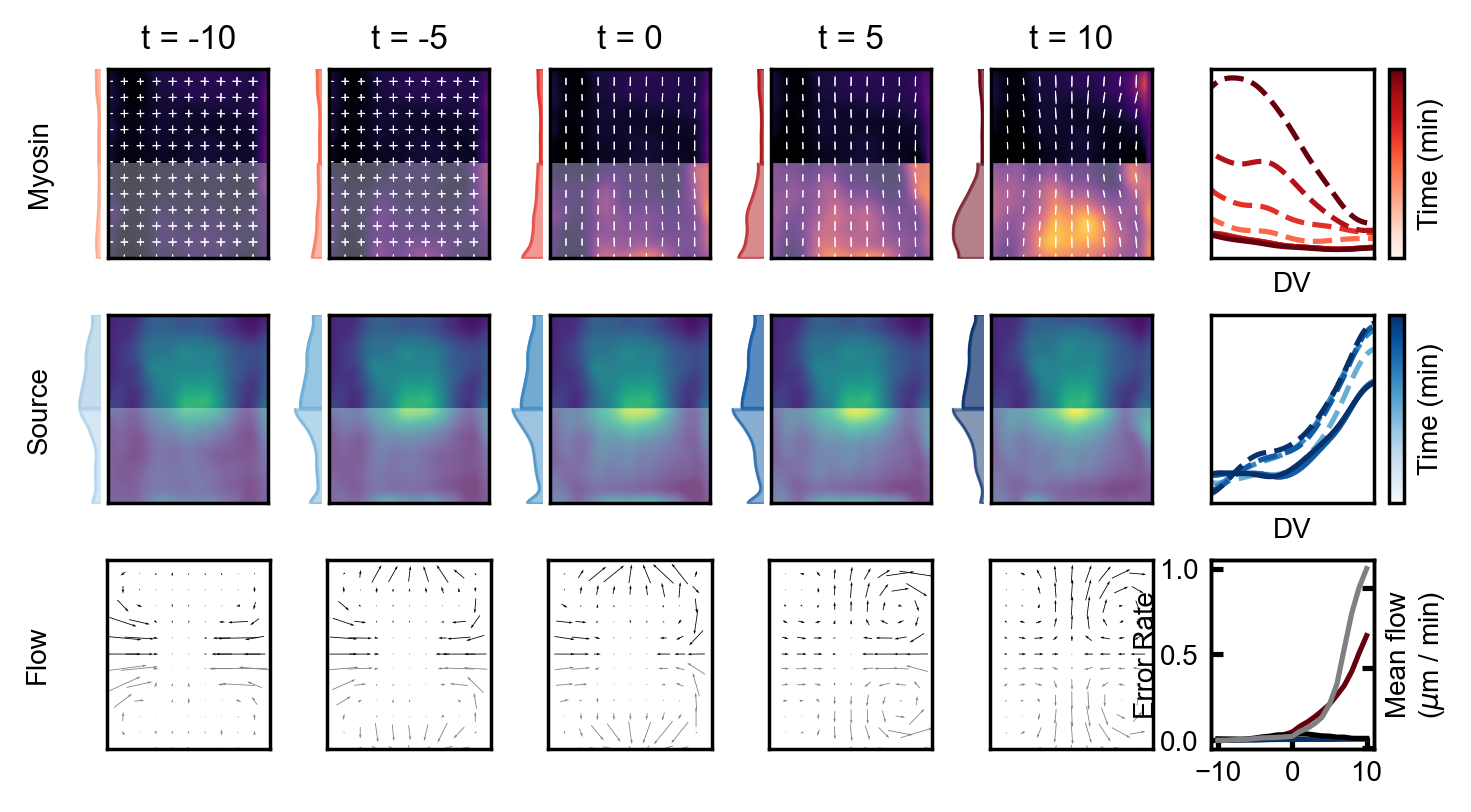

In [20]:
from utils.forecasting.transforms import *
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from scipy.interpolate import interp1d

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 10
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])

#Using a flow field interpolator in the loop instead of a neural network
v_int = interp1d(t0, v0, axis=0, fill_value='extrapolate')
v_model = lambda t, y: v_int(t)

model1 = ClosedFlyLoop(v_model)
m1, s1, v1 = model1.integrate(y0, t0)
sqh_vel_plot(m1, v1, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m1, m0),
                ('Source', s1, s0),
                ('Flow', v1, v0),
                dt=5)

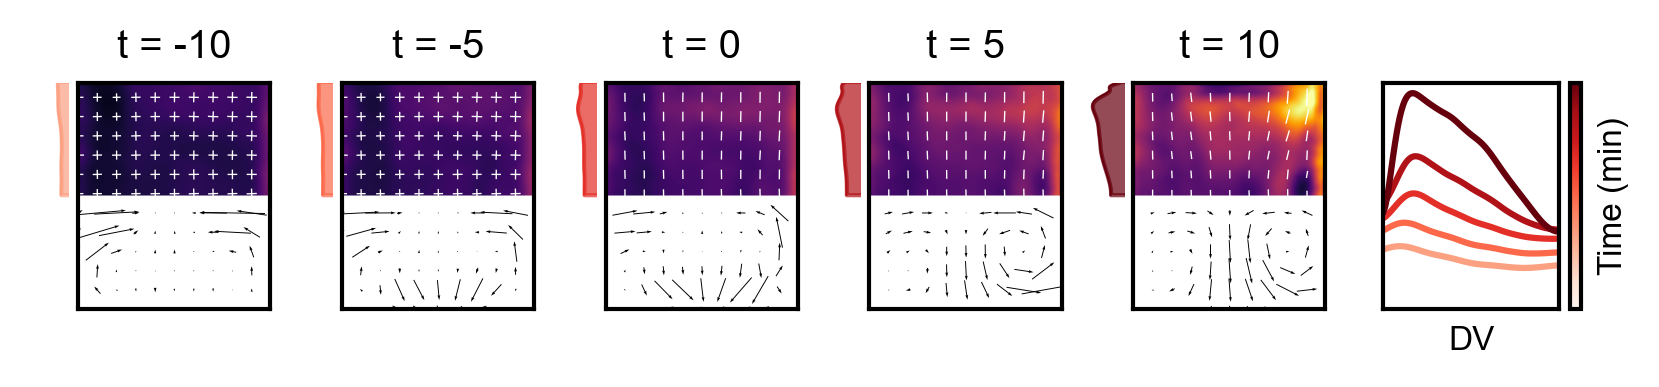

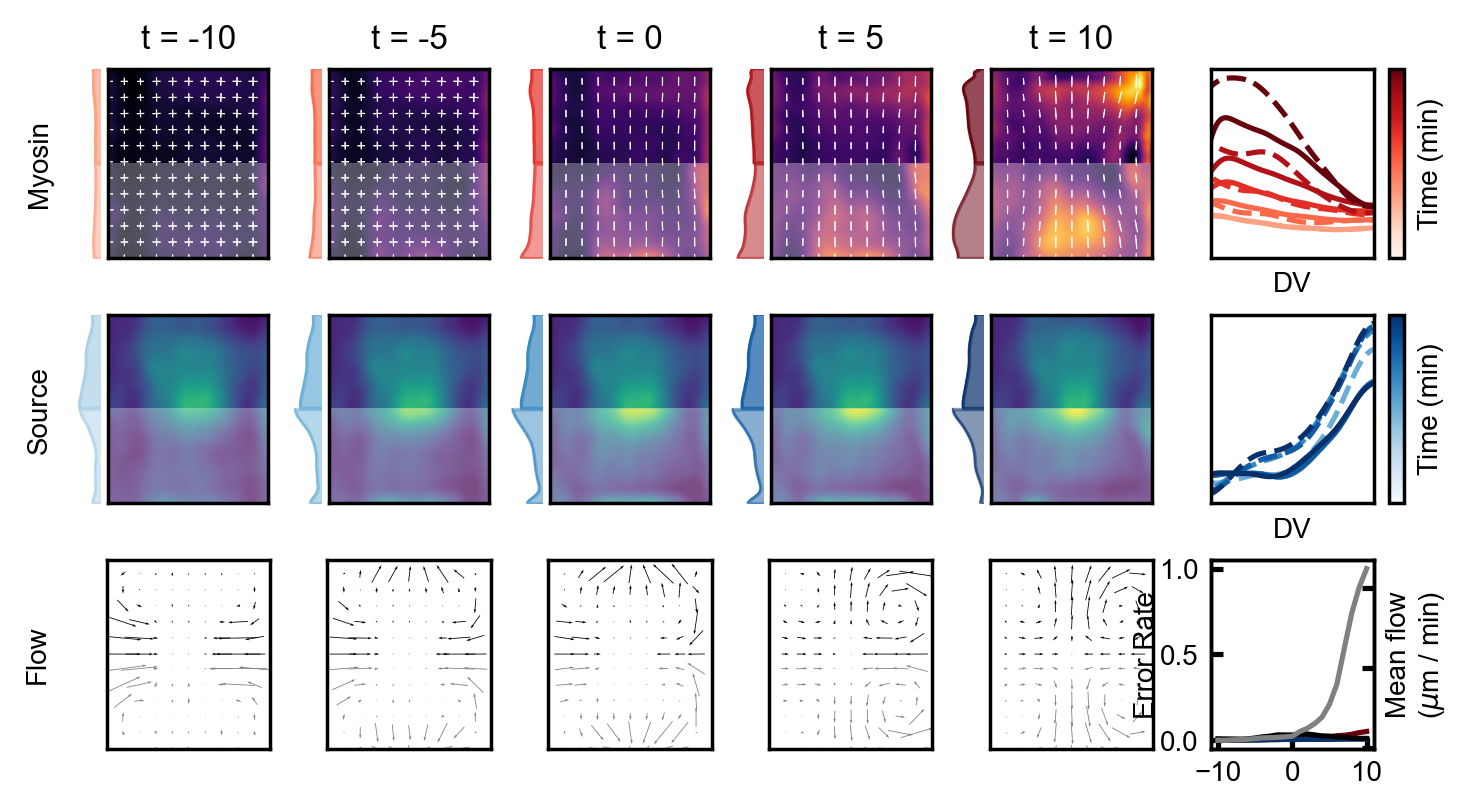

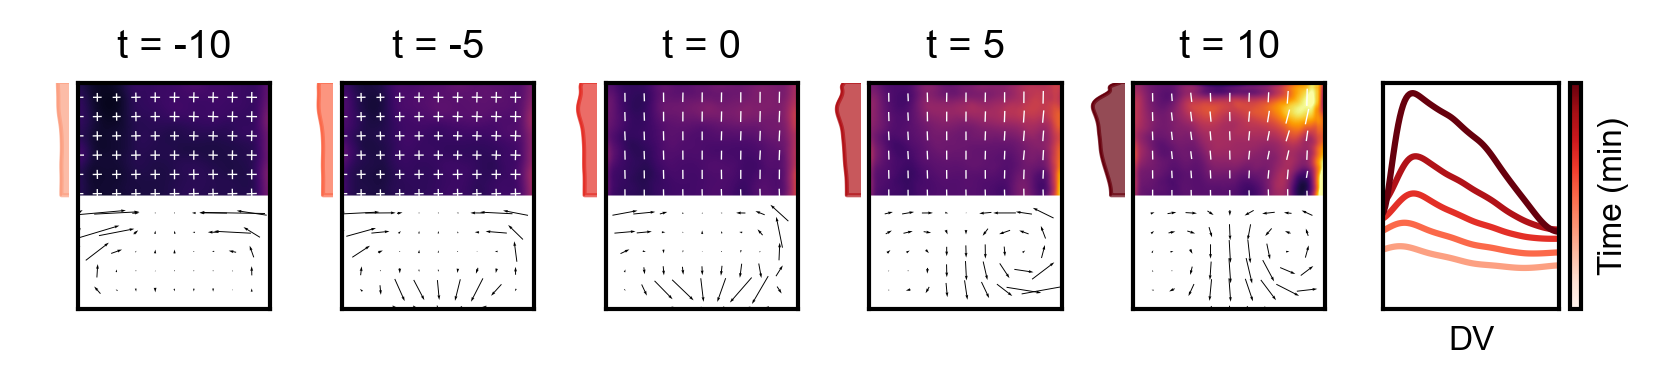

In [5]:
from utils.forecasting.transforms import *
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from scipy.interpolate import interp1d

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 10
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])

#Using a flow field interpolator in the loop instead of a neural network
v_int = interp1d(t0, v0, axis=0, fill_value='extrapolate')
v_model = lambda t, y: v_int(t)

model1 = ClosedFlyLoop(v_model, ap_mode='replicate').fit(y0)
m1, s1, v1 = model1.integrate(y0, t0)
sqh_vel_plot(m1, v1, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m1, m0),
                ('Source', s1, s0),
                ('Flow', v1, v0),
                dt=5)

model2 = ClosedFlyLoop(v_model, ap_mode='reflect').fit(y0)
m2, s2, v2 = model2.integrate(y0, t0)
sqh_vel_plot(m2, v2, t0, dt=5)

# Integrating ICs from mutant data

(107, 2, 2, 236, 200) (107, 2, 236, 200)


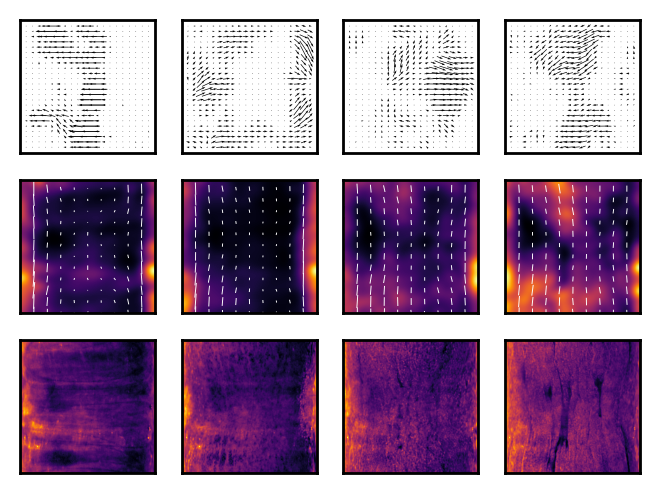

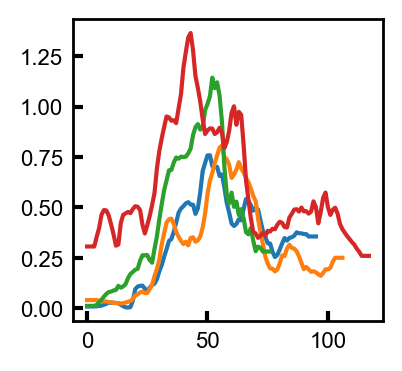

In [178]:
loaddir = 'Public/toll[RM9]/Sqh-GFP/'
loaddir = 'Public/spaetzle[A]/Sqh-GFP'
df = pd.read_csv(os.path.join(loaddir, 'dynamic_index.csv'))
embryoIDs = df.embryoID.unique()
i = 1
eId = embryoIDs[i]
edir = os.path.join(loaddir, str(eId))

raw = np.load(os.path.join(edir, 'raw2D.npy'), mmap_mode='r')
m = np.load(os.path.join(edir, 'tensor2D.npy'), mmap_mode='r')
v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')
print(m.shape, v.shape)

fig, ax = plt.subplots(3, 4, figsize=(4, 3), dpi=200)
for i, tt in enumerate(np.linspace(0, m.shape[0]-1, 4, dtype=int)):
    plot_vector2D(ax[0, i], v[tt])
    plot_tensor2D(ax[1, i], m[tt])
    color_2D(ax[2, i], raw[tt])
    ax[0, i].set_aspect('auto')
    ax[1, i].set_aspect('auto')
    ax[2, i].set_aspect('auto')

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)

for eId in embryoIDs:
    edir = os.path.join(loaddir, str(eId))
    v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')
    ax.plot(np.arange(v.shape[0]), np.linalg.norm(v, axis=1).mean(axis=(1, 2)))


(21, 2, 2, 236, 200) (21, 2, 236, 200)
(21,)
Integration status:  0 The solver successfully reached the end of the integration interval.


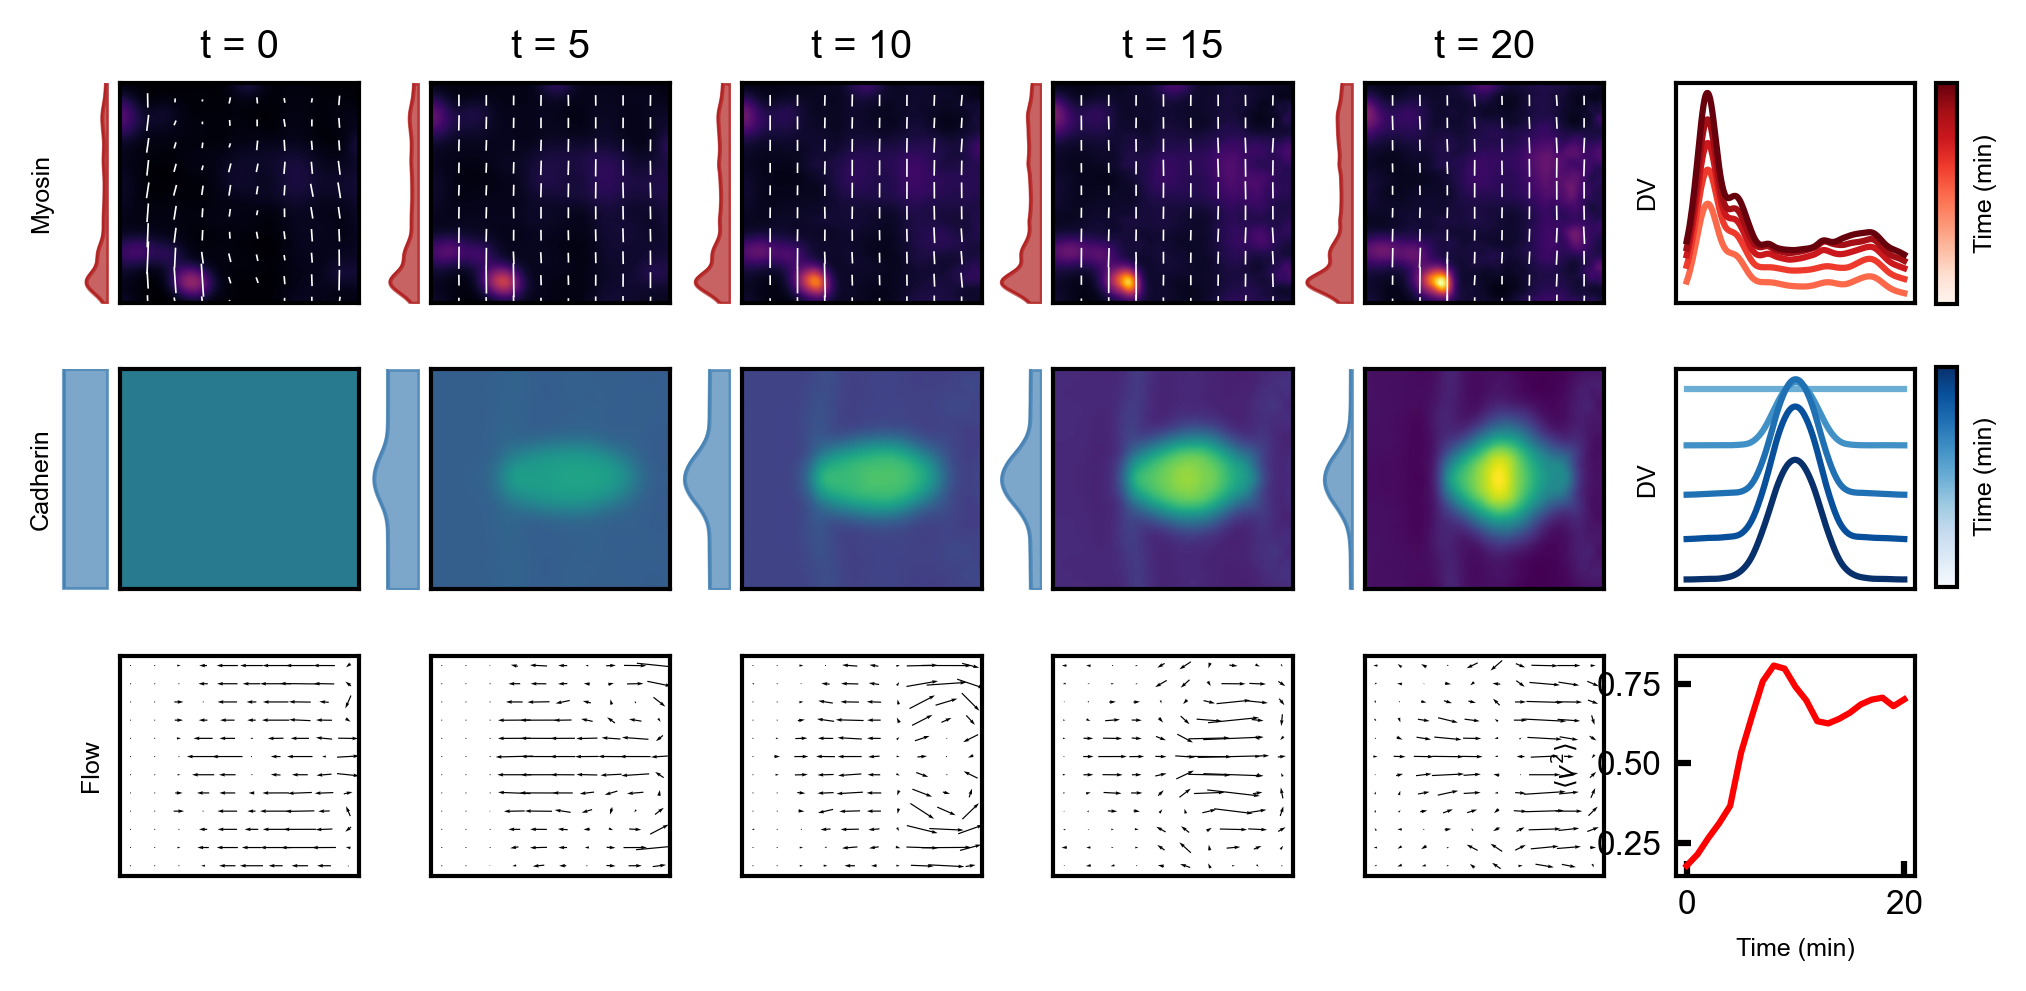

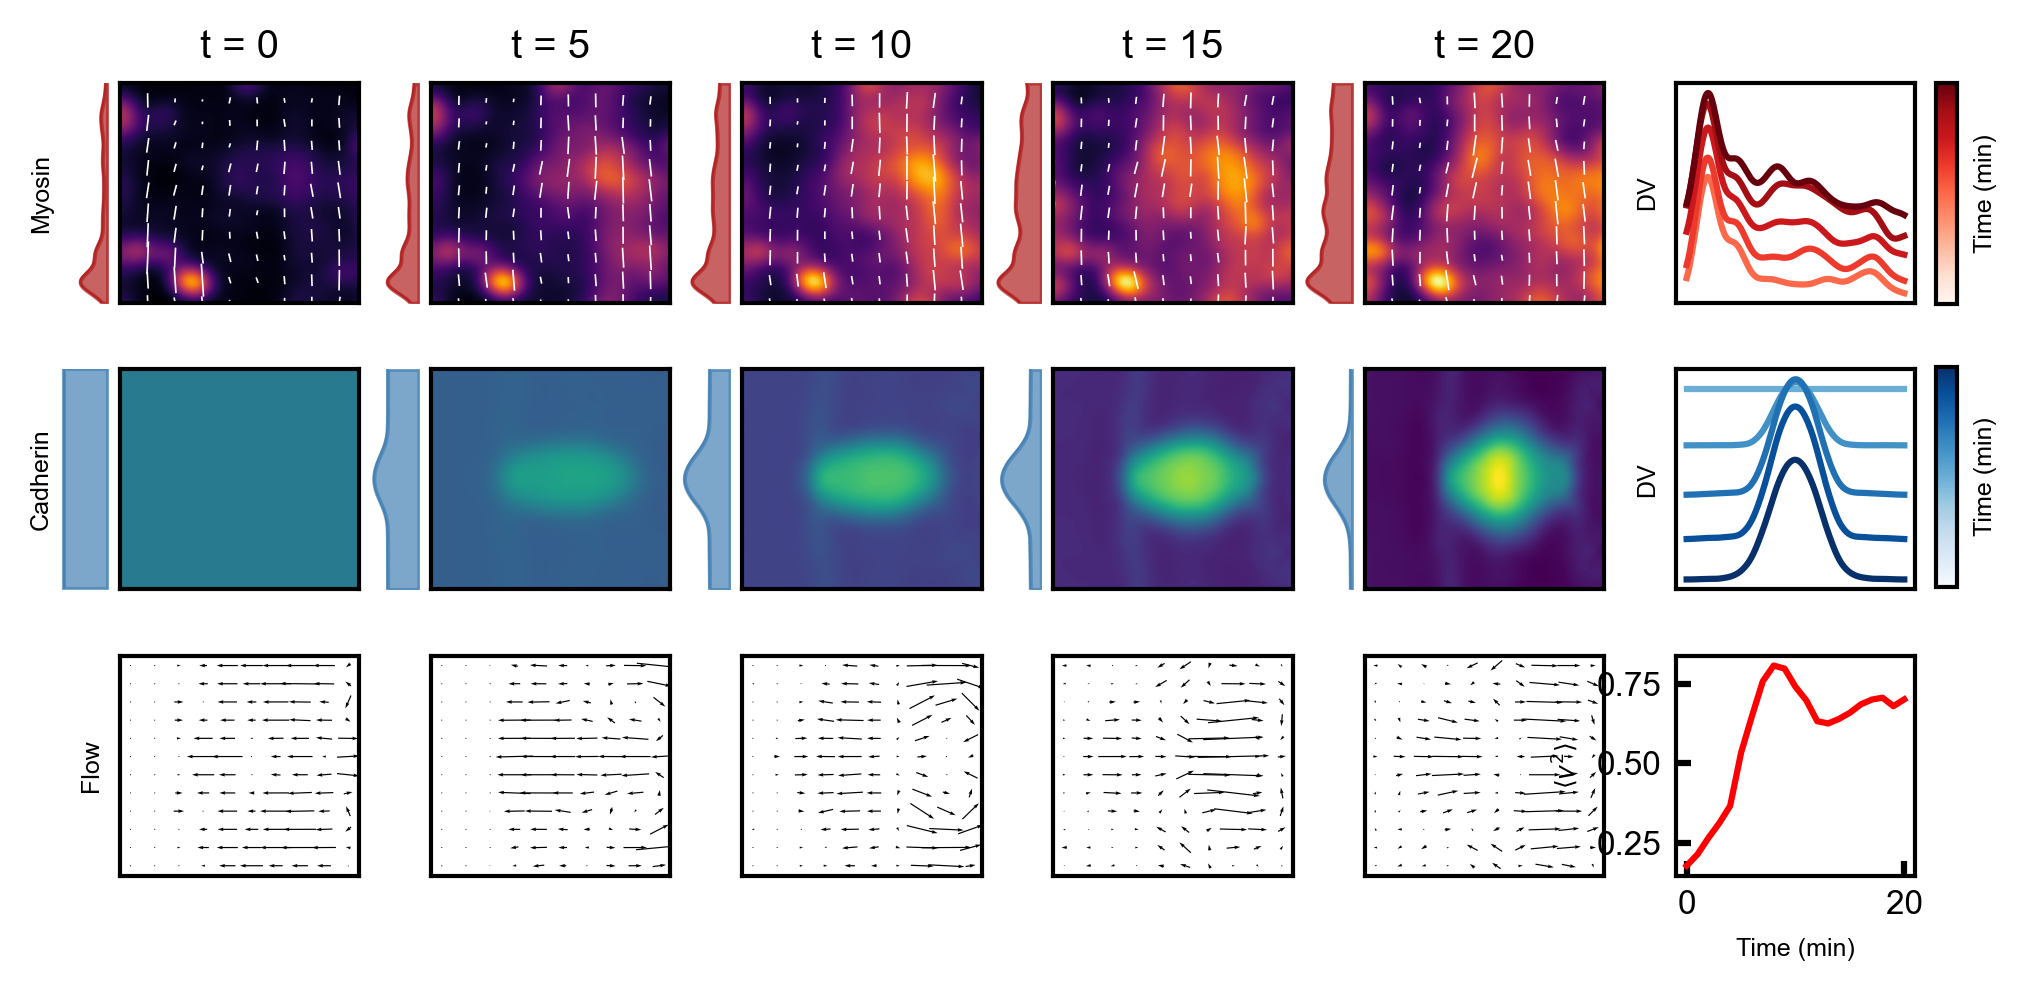

In [184]:

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, z, **kwargs):
    try:
        plot_tensor2D(ax, z, **kwargs)
    except:
        color_2D(ax, z, **kwargs)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut_Y
    
def plot(m, c, v, t, N=6, mmin=None, mmax=None, cmin=None, cmax=None, mask=None):
    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(6+1, 3.5), dpi=300)

    #Boundary crop
    if mask is None:
        mask = np.s_[...]

    if mmin is None:
        mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
        mmin = np.min(mnorm)
        mmax = np.max(mnorm)
    if cmin is None:
        cmin = np.min(c[mask])
        cmax = np.max(c[mask])
        
    cut_cad = []
    cut_sqh = []
    
    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))

        s1 = plot_with_cuts(ax1[0, i], m[dt*i][mask], 
            cmap='inferno', vmin=mmin, vmax=mmax, both=t[dt*i]<0)    
        c1 = plot_with_cuts(ax1[1, i], c[dt*i][mask],
            cmap='viridis', vmin=cmin, vmax=cmax)
        cut_cad.append(c1)
        cut_sqh.append(s1)
        y = np.linspace(*ax1[0, i].get_ylim(), len(s1))
    
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + 20)/ (np.max(t) + 20))
        cad_color=plt.get_cmap('Blues')((t[dt*i] + 20)/ (np.max(t) + 20))

        ax1[0, -1].plot(y, s1, color=sqh_color)
        ax1[1, -1].plot(y, c1, color=cad_color)

        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
    
    for i in range(N):
        cuts = [cut_sqh[i], cut_cad[i]]
        axes = ax1[:2, i]
        colors = ['firebrick', 'steelblue']
        for cut, ax, color, ax2 in zip(cuts, axes, colors, ax1[:2, -1]):
            y = np.linspace(*ax.get_ylim(), len(cut))

            ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
            ax_Y.plot(cut, y, color=color, lw=0.5)
            ax_Y.fill_betweenx(y, np.ones_like(cut)*ax2.get_ylim()[0], cut,
                               color=color, alpha=0.7)
    
            ax_Y.set(xticks=[], yticks=[])
            ax_Y.set_xlim(ax2.get_ylim())
            ax_Y.invert_xaxis()
            ax_Y.axis('off')
            
    ax1[2, -1].plot(t, np.linalg.norm(v, axis=1).mean(axis=(-2, -1)), color='red')
    ax1[2, -1].set(xlabel='Time (min)', ylabel=r'$\langle v^2 \rangle$')
    ax1[0, -1].set(xticks=[], yticks=[], ylabel='DV')    
    ax1[1, -1].set(xticks=[], yticks=[], ylabel='DV')    

    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])


    for a in ax1.flatten():
        a.set_aspect('auto')

loaddir = 'Public/toll[RM9]/Sqh-GFP/'
#loaddir = 'Public/spaetzle[A]/Sqh-GFP'
df = pd.read_csv(os.path.join(loaddir, 'dynamic_index.csv'))
embryoIDs = df.embryoID.unique()
i = 2
eId = embryoIDs[i]
edir = os.path.join(loaddir, str(eId))

t0 = 15
N = 21
m0 = np.load(os.path.join(edir, 'tensor2D.npy'), mmap_mode='r')[t0:t0+N]
v = np.load(os.path.join(edir, 'velocity2D.npy'), mmap_mode='r')[t0:t0+N]
print(m.shape, v.shape)

with h5py.File('Public/symmetric_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = 0
    tmax = 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    gamma_d = data['X_raw/Dorsal_Source'][t_mask, ...]
    gamma_dv = data['X_raw/Static_DV'][0, :, :, 0, 0]    
    c0 = data['fields/c'][t_mask, ...][()]

    
    sigma = 10
    gamma_d = gaussian_filter(gamma_d, sigma=(0, sigma, sigma))
    v = LeftRightSymmetrize().fit_transform(v)
    
    t0 = t[t_mask, ...]
    print(t0.shape)
    
    v_int = interp1d(t0, v, axis=0)
    ds_int = interp1d(t0, gamma_d, axis=0)
    
    mask = np.s_[..., 20:-20, 0:-25]
        
    c0_syn = np.ones(c0[0].shape) * np.mean(c0)

    v = v_int(t0)
    m, c, v, t = integrate(m0[0], c0_syn, v, gamma_d, gamma_dv, t0, dv, ap)
    plot(m, c, v, t, N=5, mask=mask)
    plot(m0, c, v, t, N=5, mask=mask)